In [1]:
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tree = ET.parse('HUD EF-M.xml')
mxGraphModel = tree.getroot()
root = mxGraphModel[0]
vertex = []
edges = []
iwEdges = []
for mxCell in root:
    if 'edge' in mxCell.attrib:
        if "value" in mxCell.attrib:
            edgeType = mxCell.attrib["value"]
        else:
            edgeType = ""
        if edgeType == "iw":
            iwEdges.append({"id": mxCell.attrib['id'], "type": edgeType, "source": mxCell.attrib['source'], "target": mxCell.attrib['target']})
        else:
            edges.append({"id": mxCell.attrib['id'], "type": edgeType, "source": mxCell.attrib['source'], "target": mxCell.attrib['target']})
    elif 'vertex' in mxCell.attrib:
        if "fillColor=#dae8fc;strokeColor=#6c8ebf;" in mxCell.attrib["style"]:
            vertexType = "FR"
        elif "fillColor=#fff2cc;strokeColor=#d6b656;" in mxCell.attrib["style"]:
            vertexType = "DS"
        else:
            vertexType = ""
        vertex.append({"id": mxCell.attrib['id'], "name": mxCell.attrib['value'], "type": vertexType})
    

In [5]:
edges[0]

{'id': '4ZHAvhYPEnPpfmn8iD5g-17',
 'type': 'rf',
 'source': '4ZHAvhYPEnPpfmn8iD5g-2',
 'target': '4ZHAvhYPEnPpfmn8iD5g-5'}

In [6]:
def createGraph(nodes, links):
    G = nx.DiGraph()
    for idx, node in enumerate(nodes):
        G.add_node(node['id'], name=node['name'], type=node['type'])

    for idx, link in enumerate(links):
        G.add_edge(link['source'], link['target'], type=link['type'])
    return G

In [7]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    """
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    """
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        """
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        """

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [8]:
def drawGraph(G):
    """
    Draw a graph G, styling the FRs in blue and DSs in yellow.
    :param: G: {Graph}
    """
    pos = hierarchy_pos(G)
    # extract nodes with specific setting of the attribute
    fr_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'FR']
    ds_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'DS']
    # and find all the remaining nodes.
    other_nodes = list(set(G.nodes()) - set(fr_nodes) - set(ds_nodes))

    plt.figure(3,figsize=(36,12))
    # now draw them in subsets  using the `nodelist` arg
    nx.draw_networkx_nodes(G, pos, nodelist=fr_nodes, node_size=300, \
        node_color='#0000ff', node_shape='s')
    nx.draw_networkx_nodes(G, pos, nodelist=ds_nodes, node_size=300, \
        node_color='#ffff00', node_shape='s')
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes, node_size=300, \
        node_color='purple', node_shape='o')
    nx.draw_networkx_edges(G, pos)
    #nx.draw_networkx_labels(G,pos,font_size=10)
    plt.axis('off')
    plt.show()

In [9]:
def get_children(aGraph, aNode):
    """
    Get children of aNode in aGraph.
    :param: aNode: {str} 
    :param: aGraph: {networkx.DiGraph}
    :return: {list}
    """
    try:
        children = [v for u,v,d in aGraph.out_edges(aNode, data=True)]
        return children
    except:
        print("An exception occurred")

In [10]:
G = createGraph(vertex, edges)

In [11]:
import math
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

numberOfAlternatives = 1
for node in G.nodes.items():
    if node[1]['type'] == 'FR':
        numberOfAlternatives = numberOfAlternatives * len(get_children(G,node[0]))
print(f'This project has up to {numberOfAlternatives} potential solutions!')
prob = int(np.sqrt(numberOfAlternatives))
prob_up = int(round_up(prob, -len(str(prob))+1))
prob_down = int(prob_up / 2)
print(f'But it probably has between {prob_down} and {prob_up*2} solutions. They will take around {int(prob_down/400)}-{int(prob_up*2/700)} seconds to compute.')

This project has up to 0 potential solutions!
But it probably has between 0 and 0 solutions. They will take around 0-0 seconds to compute.


In [12]:
from IPython.display import clear_output, display
import time

results = []

def calculateSolutions(G):
    
    wip = []
    solutions = []

    # Add the complete graph to wip
    allNodes = list(G.nodes)
    wip.append(allNodes)

    # While len(wip) > 0
    #   Pop a graph from 'wip'
    #   Search for the first FR with multiple alternative DS
    #   If found: Create as many alternative graphs as alternative DS the FR has
    #             Store the new graphs in 'wip'
    #   Else (if the poped graph has no FR with multiple DS): store it in 'solutions'

    while len(wip) > 0:
        # Get a new list of nodes from the 'wip' stack
        nodesList = wip.pop()
        # Create a subgraph of the main graph G, using only the nodes in the current nodesList
        graph = G.subgraph(nodesList)
        # Assume the nodes list is a candidate solution
        isCandidate = True
        # Go through the nodes in the list, searching for FRs
        for node in graph.nodes.items():
            if node[1]['type'] == 'FR':
                # Get the children of the FR (the DSs that can solve the FR)
                alternatives = get_children(graph,node[0])
                # If there are multiple alternatives, create new subgraph node lists to add to the 'wip'
                if len(alternatives) > 1:
                    # The current list of nodes can't be a solution,
                    # as there are still at least this FR with multiple DSs
                    isCandidate = False
                    # For each of the alternative DS
                    for ds in alternatives:
                        # Create a list with the nodes to remove: the DS and all its descendants
                        nodesToRemove = [ds]
                        for successor in nx.bfs_successors(graph,ds):
                            nodesToRemove += successor[1]
                        # Create a new list with the current nodes minus the nodes to remove*
                        newNodesList = [x for x in nodesList if x not in nodesToRemove]
                        # Add the new list to the 'wip'
                        wip.append(newNodesList)
                    # Done with this node list
                    break
        # If the node list didn't have any FR with multiple DSs
        if isCandidate:
            #print(f'This graph looks good: {nodesList}')
            solutions.append(nodesList)
            if len(solutions) % 1000 == 0:
                clear_output(wait=True)
                print(f'Current number of alternate solutions: {len(solutions)}')
                print(f'WIP: {len(wip)}') # use display(f) if you encounter performance issues
    return solutions

start_time = time.time()
solutions = calculateSolutions(G)
duration = time.time() - start_time
print(f'Found {len(solutions)} possible solutions in {duration} seconds.')
results.append(len(solutions)/duration)

Current number of alternate solutions: 89000
WIP: 10
Found 89874 possible solutions in 40.875699281692505 seconds.


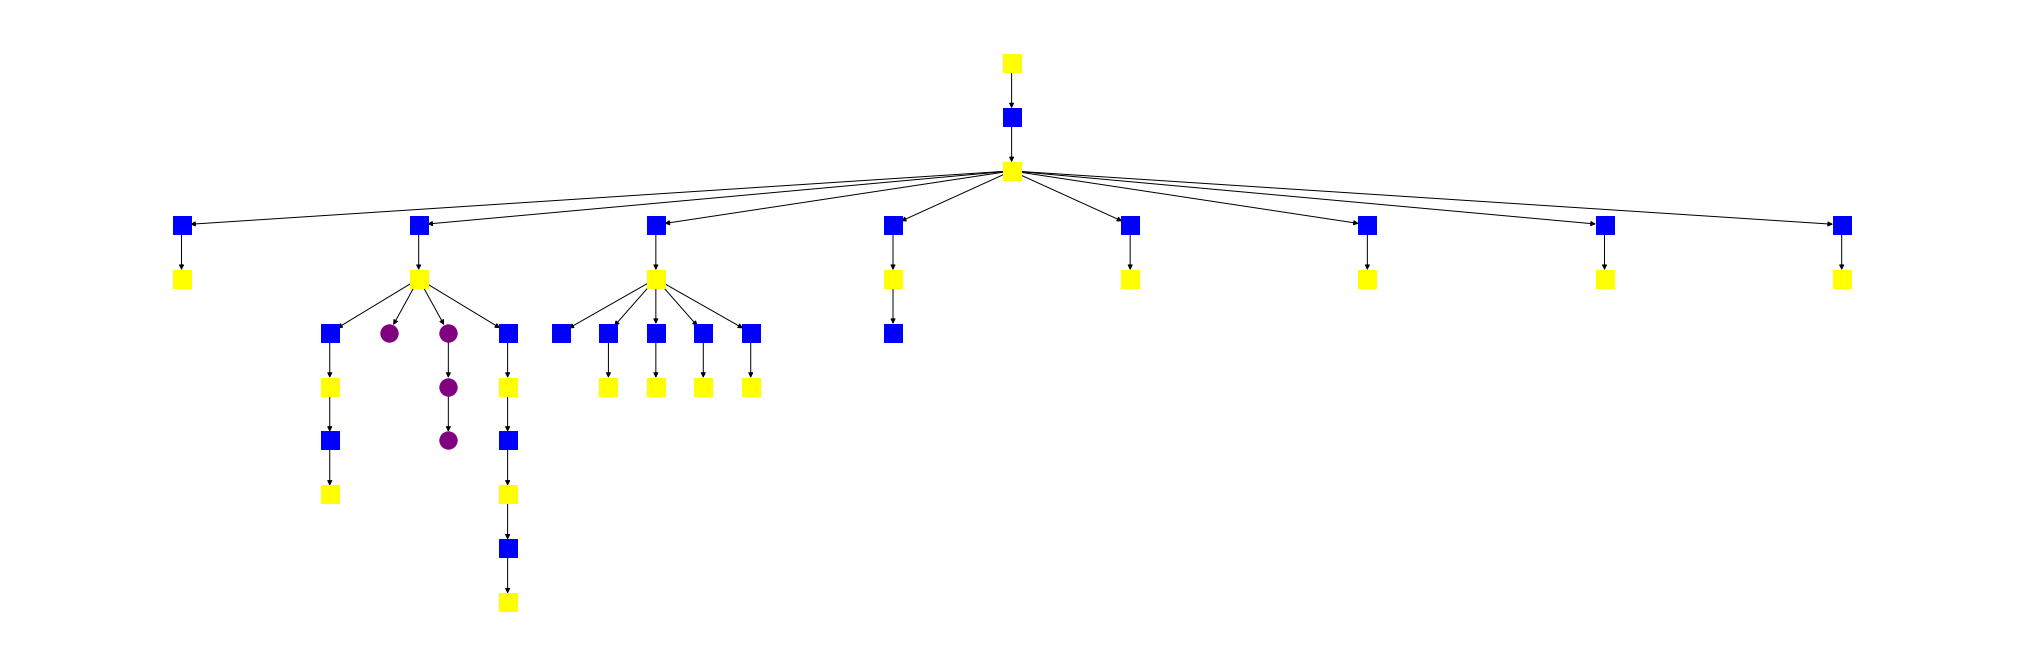

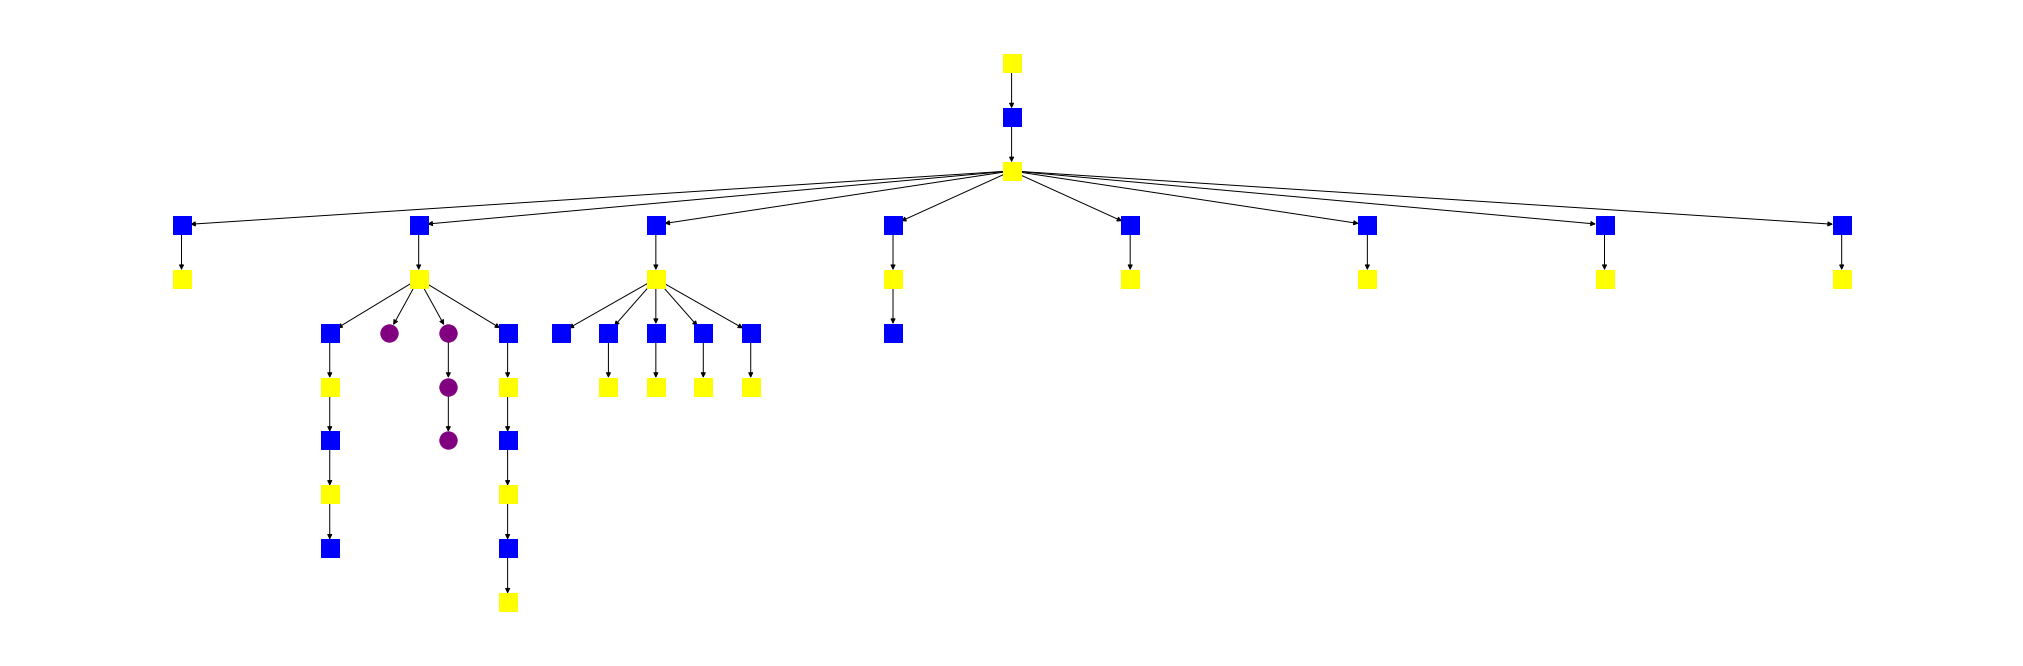

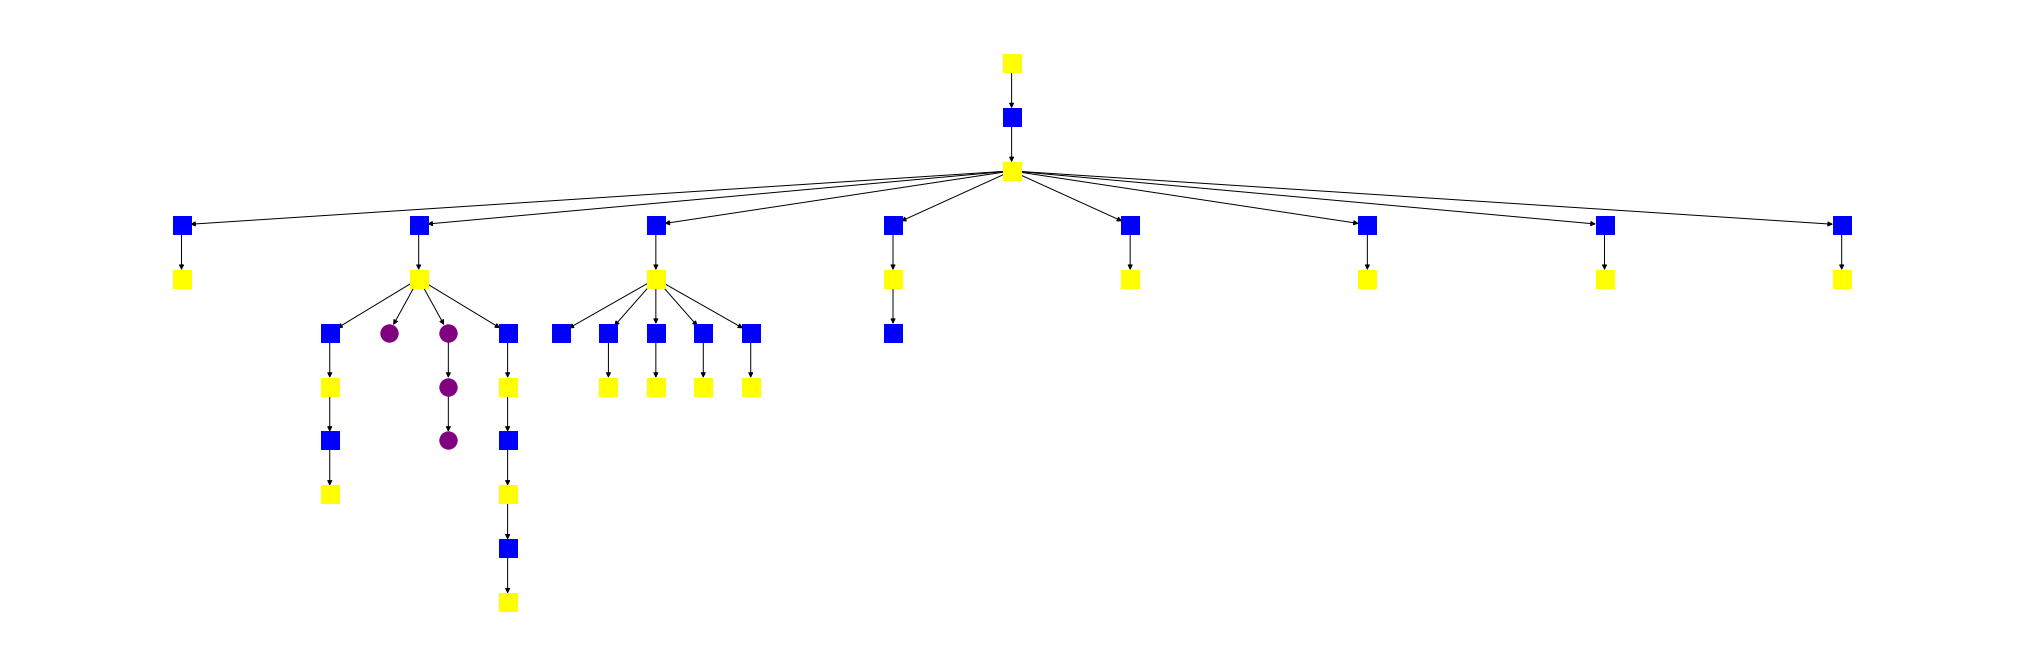

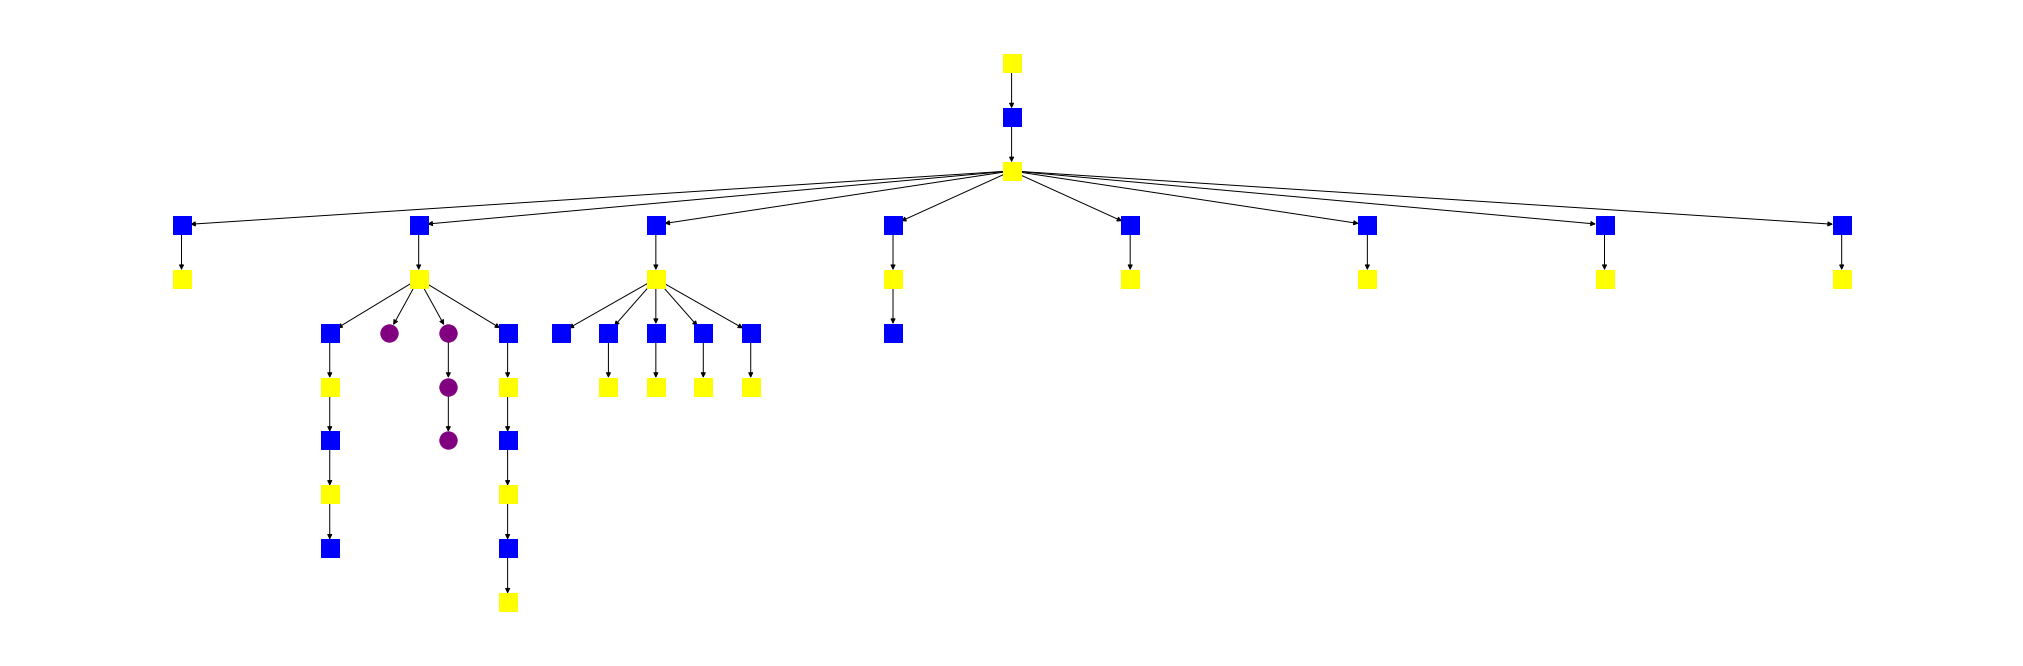

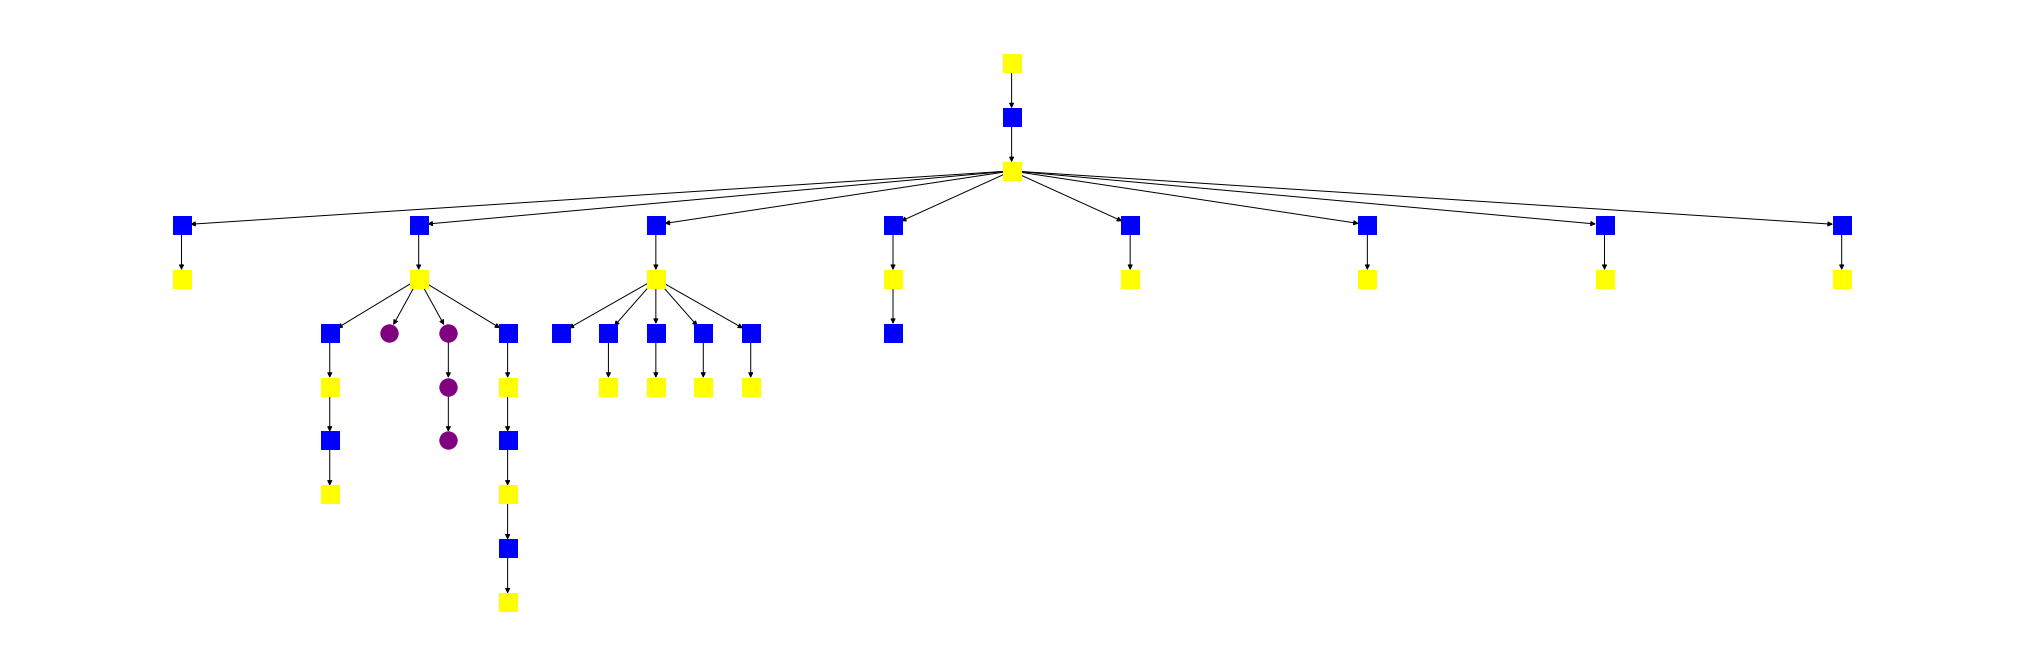

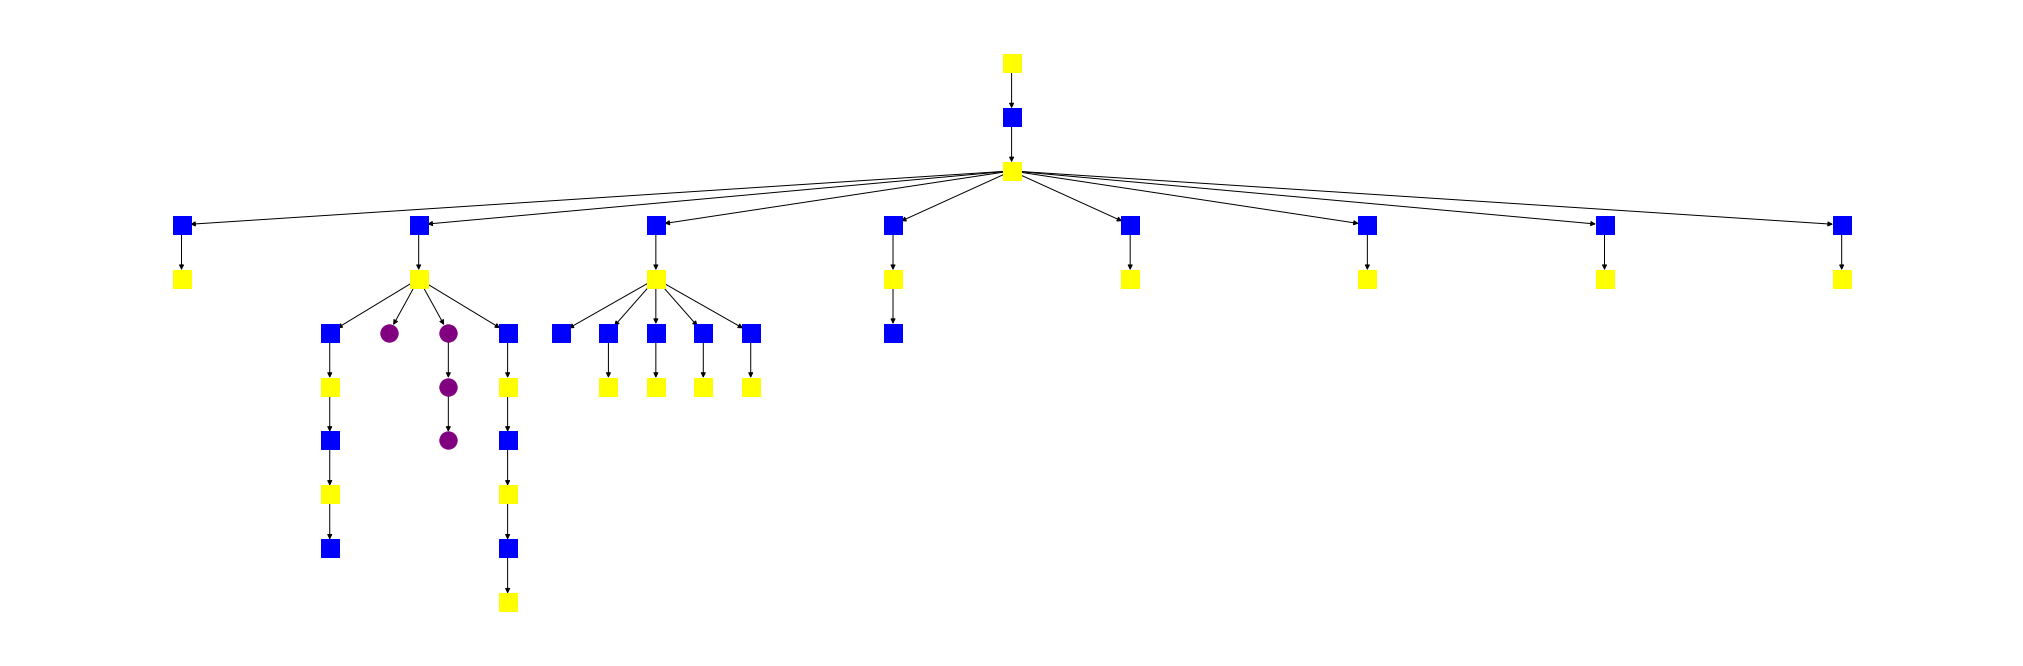

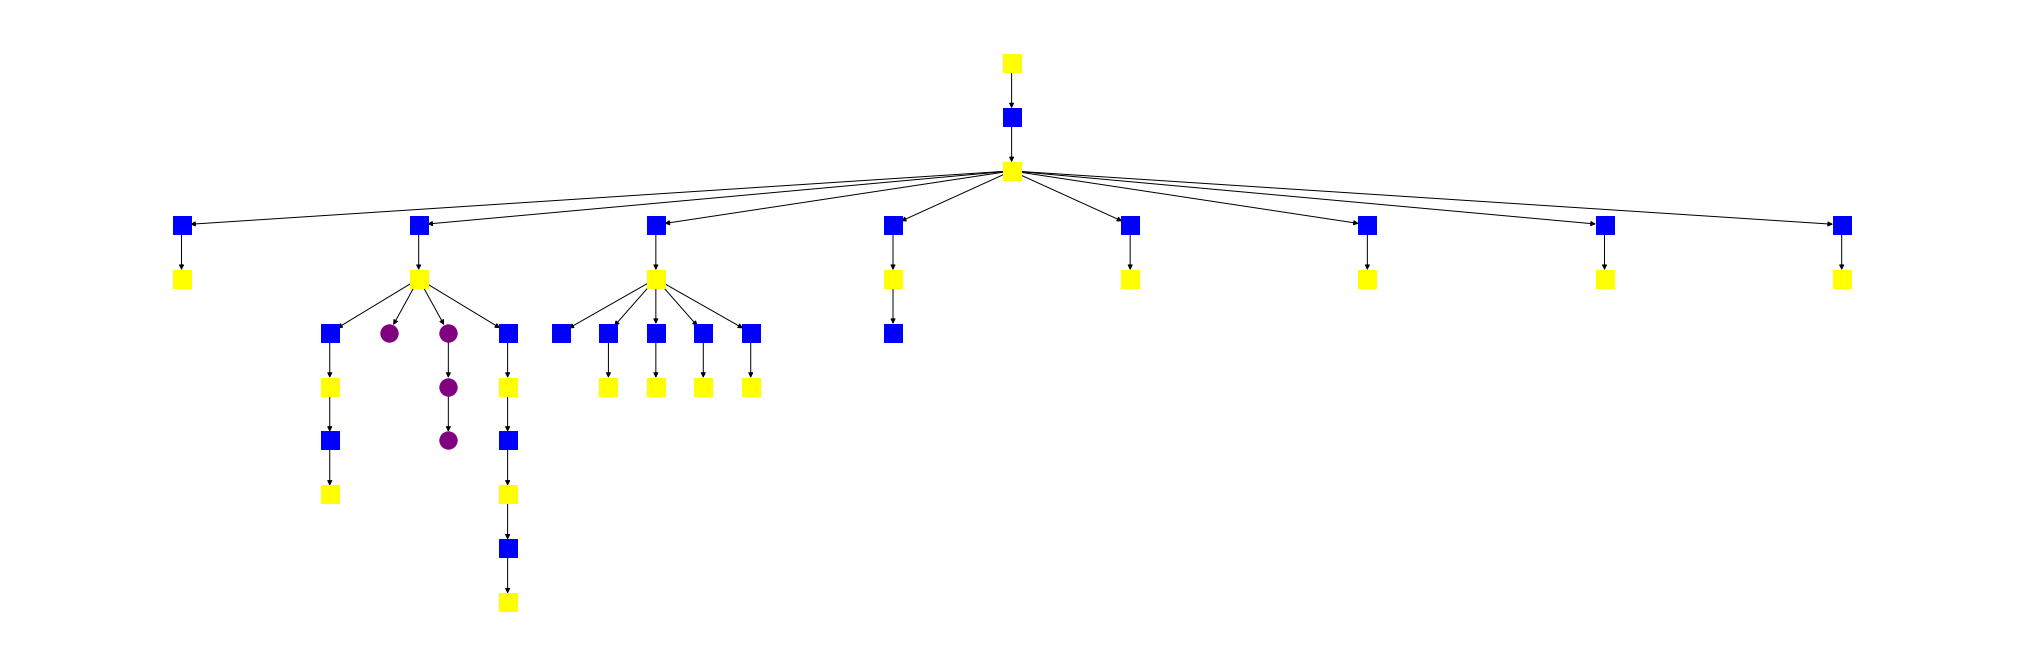

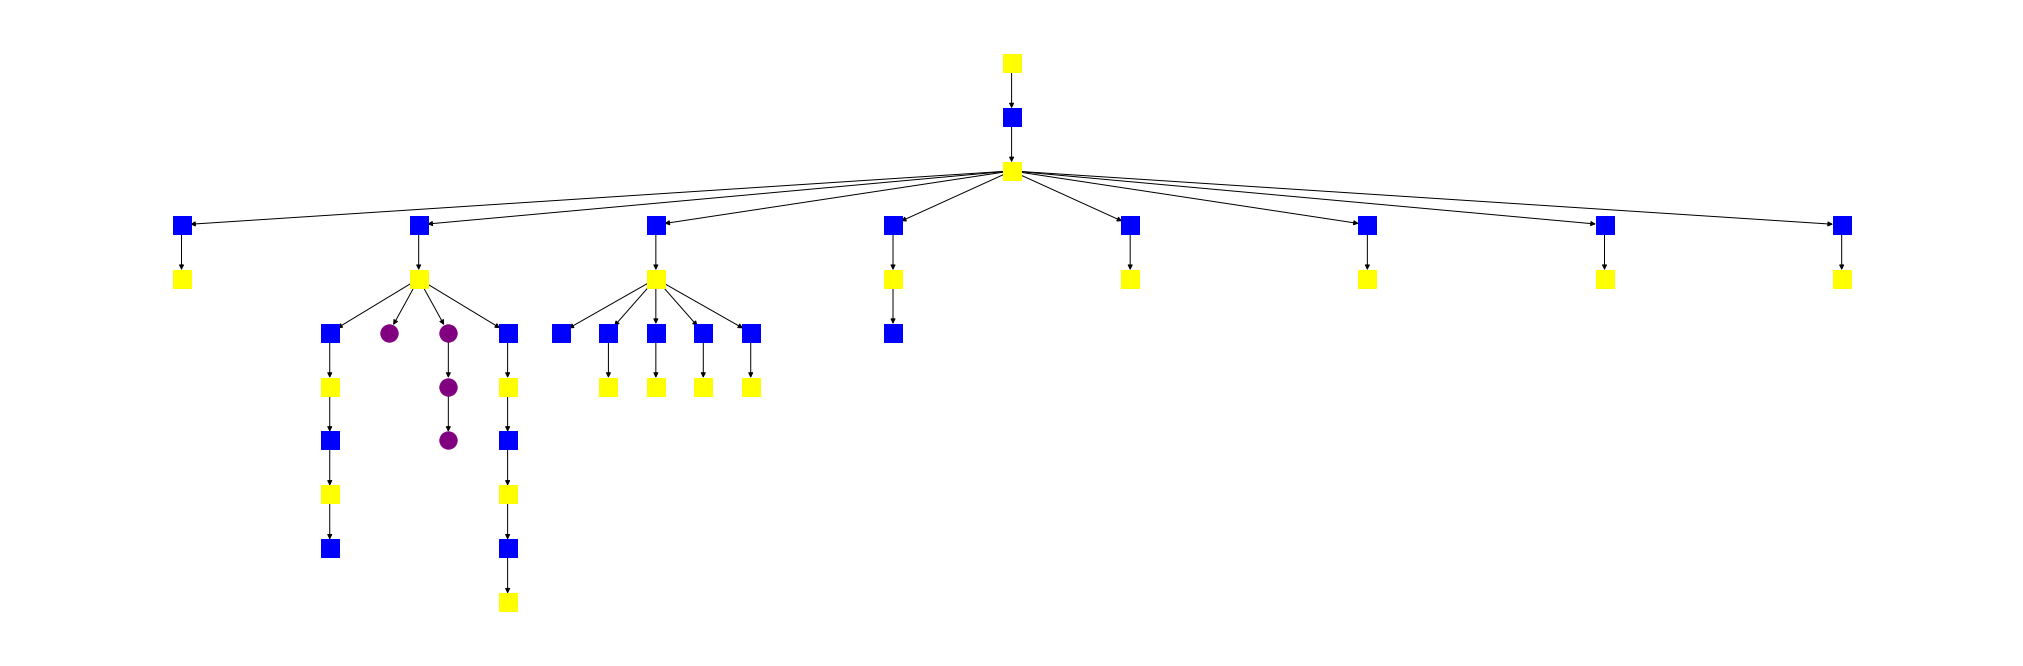

In [13]:
for solution in solutions[:8]:
    drawGraph(G.subgraph(solution))

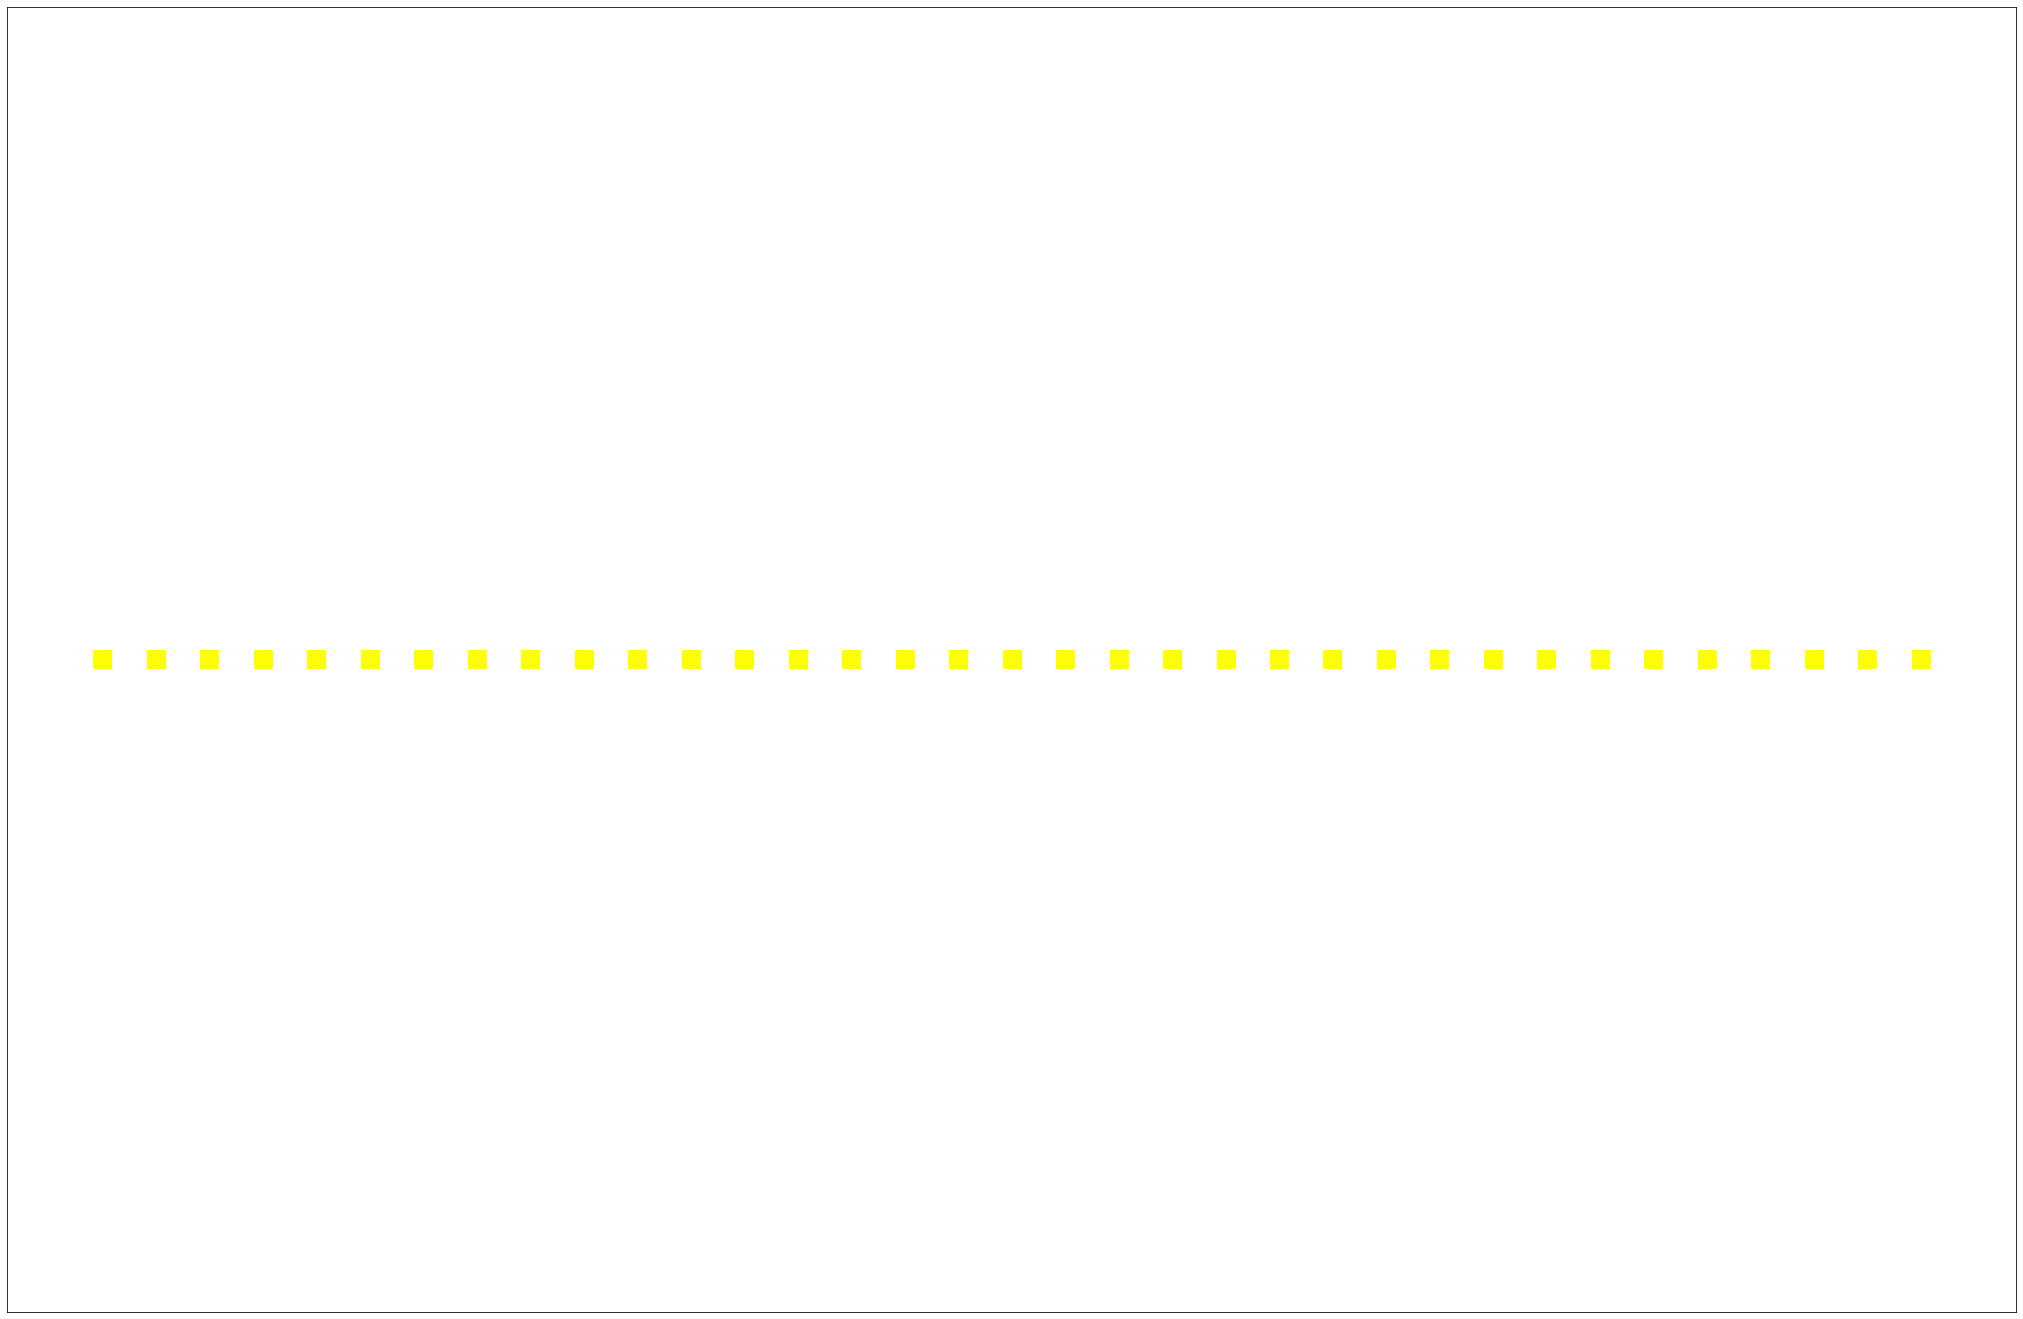

In [14]:
leafs = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]
#print(f'Leaf nodes: {leafs}')
leafVertex = list(filter(lambda d: d['id'] in leafs, edges))
iwEdgesNames = [(x['source'],x['target']) for x in iwEdges]
J = nx.DiGraph()
J.add_nodes_from(leafs)
J.add_edges_from(iwEdgesNames)
pos = nx.bipartite_layout(J, leafs, align='horizontal')
plt.figure(3,figsize=(36,24))
#nx.draw_networkx(J, pos=pos, with_labels=True)
nx.draw_networkx_nodes(J, pos=pos, nodelist=leafs, node_size=300, node_color='yellow', node_shape='s')
nx.draw_networkx_edges(J, pos=pos, edgelist=iwEdgesNames, connectionstyle='arc3, rad=0.8')
#nx.draw_networkx_labels(J,pos=pos,font_size=10)
plt.show()

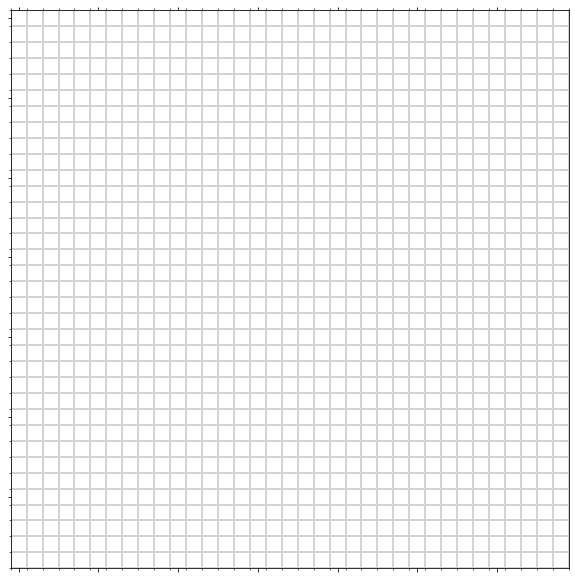

In [15]:
matrix = nx.adjacency_matrix(J)
# Display matrix
A = matrix.toarray()
size = len(A[0])

fig, ax = plt.subplots(figsize=(10,50))
ax.matshow(A,cmap='binary')
plt.axis('on')
# Minor ticks
ax.set_aspect('equal')
ax.set_xticks(np.arange(-.5, size, 1), minor=True)
ax.set_yticks(np.arange(-.5, size, 1), minor=True)
# Labels
ax.set_xticklabels("")
ax.set_yticklabels("")

# Gridlines based on minor ticks
ax.grid(which='minor', color='lightgrey', linestyle='-', linewidth=2)
plt.show()